# How we can obtain information more than PEW -> Topic Extraction
In this project, we showed  that we can have comparable results with PEW in US favorability using the QuoteBank dataset.
Here, we will go beyond a single sentiment extracted form quotes. We will find the positive and negative topics people
 around the world have about the US image.
The steps are as follows:

1. Sampling the new filtered data
2. Tokenization
3. Train an LDA model
4. Visualize the topics
5. Labeling the topics
6. Topic detection group by countries


## 1. Sampling the new filtered data
In this part, we load the filtered data year by year and concatenate into a single dataframe.
Since we would like to apply an unsupervised learning on the dataset, we don't need anymore to drop the None-speakers
quotes, and we don't consider the nationalities in the topic detection training.

The problem is that the amount of data is huge and we cannot load them all to train the topic detection model.
The first solution is to load the data year by year and train the LDA model iteratively. The second solution which is
more advanced is to randomly sample the quotations. However, we sample the quotes proportionally to the num_occurrence
in the QuoteBank, i.e., the more frequently a quote shows, the more probable to be chosen. Then, we can cover the most
important quotes for the topic extraction.

In [30]:
import pandas as pd

def get_sample(ratio, df):
    occurrence_weight = df["numOccurrences"]/df["numOccurrences"].sum()
    sample_num = int(ratio * len(df))
    df_sampled = df.sample(n=sample_num, weights=occurrence_weight)
    return df_sampled

US_data = pd.DataFrame()
for year in range(2015, 2021) :
    year_df = pd.read_pickle('input/us_{}media.pkl.bz2'.format(year), compression='bz2')
    year_df = year_df.drop_duplicates(subset='quoteID', keep='first')
    # Remove the duplication in the dataset
    # Apply a random sampling proportional to the numOccurrences
    sampled_year_df = get_sample(ratio=0.1, df=year_df)
    US_data = pd.concat([US_data, sampled_year_df], axis=0)


US_data.sample(n=4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,sentiment
15533,2017-06-23-100228,The fact that Warmbier died suddenly in less t...,None,[],2017-06-23 00:00:00,247,"[[None, 0.7073], [Otto Warmbier, 0.1843], [Pre...",http://chronicle.northcoastnow.com/national-ne...,E,-0.994367
290962,2017-05-22-083046,The bar for success has been set extremely low...,None,[],2017-05-22 00:00:00,15,"[[None, 0.9293], [President Donald Trump, 0.05...",http://feeds.foxbusiness.com/~r/foxbusiness/la...,E,-0.865549
488784,2019-11-19-027664,History is unfolding on Capitol Hill while mos...,None,[],2019-11-19 05:00:00,2,"[[None, 0.5763], [Michael Copps, 0.3349], [Mik...",https://www.commondreams.org/news/2019/11/19/b...,E,0.778432
209410,2017-09-11-077182,"Now, if he'd somehow managed miraculously to g...",George Clooney,[Q23844],2017-09-11 05:56:00,18,"[[George Clooney, 0.8305], [None, 0.1237], [St...",https://www.washingtonpost.com/news/morning-mi...,E,-0.480984


As we can see in the data frame, the numbers of occurrence of the chosen samples are high.

## 2. Tokenization
As we learned in the ADA course, the first step to apply the text analysis is to tokenize the text into vectors and BoW.
Here, thanks to the nltk library, we first do the sentence tokenization to split the quotes into sentences. Then, the sentences should be split to
words and the stop words should be applied to the quotes. The stop words are the common stop words in English + the
keywords that we have used for the quoteBank filtering.


In [31]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from itertools import chain
nltk.download('stopwords')
nltk.download('punkt')
# Turn every quotes to a list of sentences
US_data["sentences"] = US_data.quotation.apply(lambda x: sent_tokenize(x))

# Turn sentences to words
US_data["token_sentences"] = US_data.sentences.apply(lambda  x: [word_tokenize(sentence) for sentence in x])

# Create the stopwords
US_keywords = ["us", "u.s", "usa", "united", "states", "american", "americans"]
speaker_keywords = ["trump", "york", "washington", "biden", "obama", "warren",
            "sanders", "hollywood", "harris", "cohen", "apple", "nixon",
            "clinton", "williams", "bush", "lincoln", "kennedy", "pompeo",
            "donald", "ocasio", "pence", "tesla", "don", "nelson",
            "tarantino", "baldwin", "bannon", "bolton", "barr"]
my_stopwords = stopwords.words('english') + US_keywords + speaker_keywords

# Apply the stopwords and lower case the tokens
US_data["tokens"] = US_data.token_sentences.apply(lambda sentences: list(chain.from_iterable(sentences)))
US_data["tokens"] = US_data.tokens.apply(lambda tokens: [token.lower() for token in tokens if token.isalpha()
                                                    and token.lower() not in my_stopwords and len(token)>1] )
US_data.sample(n=6)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alireza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,sentiment,sentences,token_sentences,tokens
99497,2020-03-18-003562,American adults of all ages -- not just those ...,Brian Stelter,[Q4965386],2020-03-18 23:26:55,1,"[[Brian Stelter, 0.5795], [None, 0.2192], [Ste...",http://m.nzherald.co.nz/world/news/article.cfm...,E,0.248966,[American adults of all ages -- not just those...,"[[American, adults, of, all, ages, --, not, ju...","[adults, ages, seriously, sickened, coronaviru..."
194169,2018-01-29-108319,The EU stands ready to react swiftly and appro...,Margaritis Schinas,[Q11266281],2018-01-29 00:00:00,276,"[[Margaritis Schinas, 0.88], [None, 0.092], [P...",http://chronicle.northcoastnow.com/national-ne...,E,0.784790,[The EU stands ready to react swiftly and appr...,"[[The, EU, stands, ready, to, react, swiftly, ...","[eu, stands, ready, react, swiftly, appropriat..."
172281,2018-08-30-018455,Dialogue and consultation based on equality an...,Gao Feng,"[Q16231274, Q16908273, Q24834646, Q3095227, Q4...",2018-08-30 00:00:00,38,"[[Gao Feng, 0.6282], [None, 0.3693], [Presiden...",http://feeds.foxbusiness.com/~r/foxbusiness/la...,E,0.713423,[Dialogue and consultation based on equality a...,"[[Dialogue, and, consultation, based, on, equa...","[dialogue, consultation, based, equality, good..."
410857,2018-04-19-069829,"In recognition of Earth Day, we are making it ...",Lisa Jackson,"[Q16218554, Q27469861, Q445734, Q476660, Q6557...",2018-04-19 17:00:00,120,"[[Lisa Jackson, 0.8586], [None, 0.1414]]",http://www.businesswire.com/news/home/20180419...,E,0.997531,"[In recognition of Earth Day, we are making it...","[[In, recognition, of, Earth, Day, ,, we, are,...","[recognition, earth, day, making, simple, poss..."
64497,2018-07-17-111023,"Who do believe more, Russia or your own U.S. i...",President Trump,[Q22686],2018-07-17 01:40:41,1,"[[President Trump, 0.8619], [None, 0.0665], [V...",https://www.newsbusters.org/blogs/nb/nicholas-...,E,0.865360,"[Who do believe more, Russia or your own U.S. ...","[[Who, do, believe, more, ,, Russia, or, your,...","[believe, russia, intelligence, officials]"
279862,2018-09-21-027845,He takes some parts of conservatism very serio...,None,[],2018-09-21 16:51:19,12,"[[None, 0.7723], [Mitch McConnell, 0.2156], [P...",https://www.heraldonline.com/news/politics-gov...,E,-0.398473,[He takes some parts of conservatism very seri...,"[[He, takes, some, parts, of, conservatism, ve...","[takes, parts, conservatism, seriously, judges..."


## 3. Train an LDA model
Here we go! We have the tokens for every rows and need to train an LDA model with them. First we initialize a dictionary
and corpus based on the tokens we obtained. Then, we will find $n$ topics for our dataset. But wait! What is $n$?

In [ ]:
from gensim import corpora
tokens = US_data.tokens.tolist()
# get the dictionary for the tokens
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]


To choose the best value for $n$ we perform the training for several values of $n$ on a smaller dataset. Then, we decide
the optimal number of $n$ based on the **Coherence Score**.  This scores shows how much the tokens are correalted with
the topics we extract.

In [ ]:
from gensim import models
# We choose the number of topics in logarithmic steps
for num_topics in [25, 50, 75, 100, 150, 200, 500]:
    lda_model = models.LdaModel(corpus, num_topics=num_topics,
                                id2word=dictionary_LDA,
                                alpha='auto',
                                eta='auto',
                                passes=4)
    coherence_model_lda = models.CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary_LDA, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Num Topics: {}, Coherence Score: {}'.format(num_topics, coherence_lda))


We got the following results by running the above code on the server.

| Number of Topics | 25 | 50 | 75 | 100 | 150 | 200 | 500
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| Coherence Score | 0.344 | 0.390 | 0.392 | 0.413 | 0.482 | 0.537 | 0.622

We choose a number of topic that marks the end of a rapid growth of calculated topic coherence. Thus, we chose 150
number of topics to have meaningful and interpretable topics. For the number of topic >= 200, we got lots of keywords
repeated in several topics.

In [ ]:
from gensim import models
optimal_num_topics  = 150
optimal_model = models.LdaModel(corpus, num_topics=optimal_num_topics,
                                id2word=dictionary_LDA,
                                alpha='auto',
                                eta='auto',
                                passes=4)



In [ ]:
# save the LDA model, the dictionary and the corpus
optimal_model.save("output/topic/topic_model_150")
dictionary_LDA.save("output/topic/dictionary_150")
corpora.MmCorpus.serialize("output/topic/corpus", corpus)

## 4. Visualize the topics
In this section we are going to visualize and show the topics that we have extracted from the previous part.
So, let's start with a nice visualization!

In [32]:
# Load the optimal model firsst
from gensim import models, corpora
temp_file = "output/topic/topic_model_150"
optimal_model = models.LdaModel.load(temp_file)
lda_dict = corpora.Dictionary.load("output/topic/dictionary_150")

In [ ]:
# Train a pyLDAvis with the model, corpus and dictionary
!pip install pyLDAvis
num_topics = 150
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(topic_model=optimal_model, corpus=corpus, dictionary=dictionary_LDA, mds='mmds')
pyLDAvis.save_html(LDAvis_prepared, 'output/ldavis_prepared_'+ str(num_topics) +'total.html')

You can see this representation in the data story. Another way of the representation is to show the kerywords of topics
inside a wordcloud. We show the first 24 topics here in a figure.

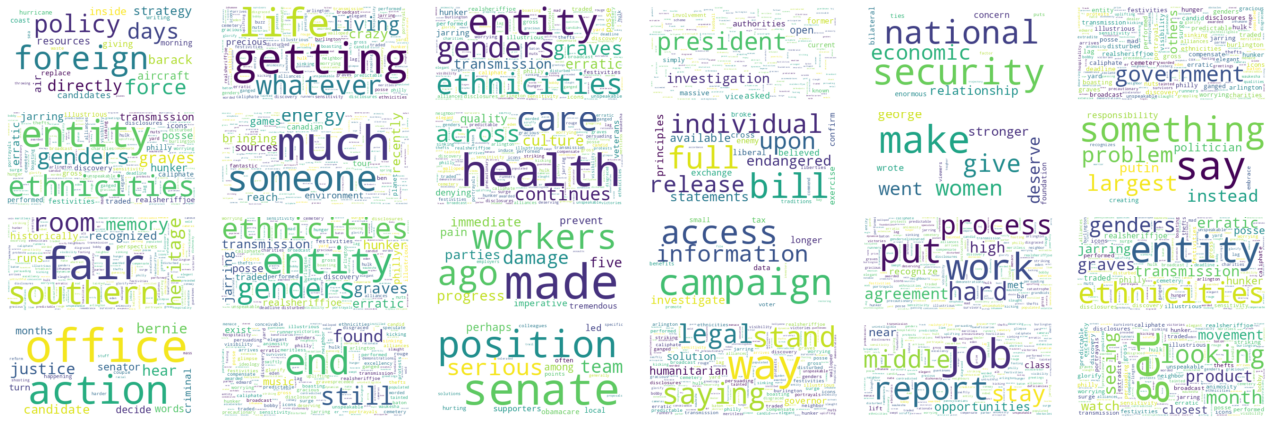

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig = plt.figure(figsize=(18,6))
for i in range(24):
    plt.subplot(4,6,i+1)
    plt.imshow(WordCloud(background_color="white").fit_words(dict(optimal_model.show_topic(i, 200))),
               interpolation='bilinear')
    plt.axis("off")
plt.tight_layout()
plt.savefig('output/wordcloud.png')

As shown in the figure, we can find the main topic more or less from the word clouds.

## 5. Labeling the topics
In this project, we want to find the topics for US favorability to see what was the positive and negative sides of the
US image in every country. Therefore, we need to set a name for every topic. We call this process as topic labeling.

To obtain the name for every topic, first we show the most used keywords inside the topics. Then, for every single
topic, we extract the most correlated quotation to them. Considering the keywords and 3 most related quotations we set
manually the name for every topic.

In [34]:
# Show 10 keywords per topic
for i,topic in optimal_model.show_topics(formatted=True, num_topics=150, num_words=8):
    print(str(i)+": "+ topic)

0: 0.269*"foreign" + 0.137*"policy" + 0.108*"days" + 0.097*"force" + 0.048*"directly" + 0.046*"strategy" + 0.045*"barack" + 0.035*"aircraft"
1: 0.342*"getting" + 0.284*"life" + 0.167*"whatever" + 0.080*"living" + 0.079*"crazy" + 0.021*"precious" + 0.000*"newtown" + 0.000*"ratify"
2: 0.000*"cheered" + 0.000*"scream" + 0.000*"newtown" + 0.000*"soared" + 0.000*"heavens" + 0.000*"sam" + 0.000*"ratify" + 0.000*"neurotic"
3: 0.739*"president" + 0.068*"investigation" + 0.033*"open" + 0.025*"asked" + 0.023*"authorities" + 0.021*"former" + 0.020*"vice" + 0.018*"massive"
4: 0.387*"security" + 0.309*"national" + 0.105*"economic" + 0.082*"relationship" + 0.032*"concern" + 0.023*"bilateral" + 0.019*"enormous" + 0.017*"ties"
5: 0.876*"government" + 0.115*"others" + 0.000*"cheered" + 0.000*"newtown" + 0.000*"soared" + 0.000*"heavens" + 0.000*"sam" + 0.000*"toon"
6: 0.000*"cheered" + 0.000*"scream" + 0.000*"newtown" + 0.000*"soared" + 0.000*"heavens" + 0.000*"sam" + 0.000*"ratify" + 0.000*"neurotic"
7

We extracted the keywords, and now, we will see which quotes are realted to these topic the most.

In [35]:
# for every row, get the dominant topic and its probability
def get_dominant_topic(tok):
    topics_prob = optimal_model[lda_dict.doc2bow(tok)]
    topics_sorted = sorted(topics_prob, key=lambda x: (x[1]), reverse=True)
    dominant_num, dominant_prop = topics_sorted[0]
    return dominant_num, dominant_prop

US_data['topic'] = US_data.tokens.apply(lambda x: get_dominant_topic(x))


In [36]:
# we extract the number of topic and the probability in separated columns
topic_labeling_df = US_data[['quotation', 'topic']]
topic_labeling_df["topic_num"] = topic_labeling_df.topic.apply(lambda x: x[0])
topic_labeling_df["topic_prob"] = topic_labeling_df.topic.apply(lambda x: x[1])
topic_labeling_df.sample(n=10)

/tmp/ipykernel_6365/868583773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_labeling_df["topic_num"] = topic_labeling_df.topic.apply(lambda x: x[0])
/tmp/ipykernel_6365/868583773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_labeling_df["topic_prob"] = topic_labeling_df.topic.apply(lambda x: x[1])


,quotation,topic,topic_num,topic_prob
252896,Although confidence in Putin's handling of for...,"(3, 0.124884866)",3,0.124885
140339,the United States could lead a coalition of la...,"(131, 0.13876782)",131,0.138768
4852,suspend immigration from areas of the world wh...,"(128, 0.10527353)",128,0.105274
655699,With so many people in our community threatene...,"(125, 0.1924466)",125,0.192447
169574,"It was from the States, so you know, anything ...","(96, 0.18015473)",96,0.180155
65588,New York state will pay any person who is quar...,"(69, 0.5180287)",69,0.518029
3506,Britain has much less to give than Europe as a...,"(10, 0.23644315)",10,0.236443
78617,"Under the executive order, (U.S. Custom and Im...","(136, 0.35129026)",136,0.351290
483405,"He was a pioneer in a lot of areas, including ...","(72, 0.15240188)",72,0.152402
380634,To have an entire film of Asian faces and then...,"(123, 0.21191622)",123,0.211916


In [37]:
# First, we sort the rows based on the probabilty. The head has the most confidence of topic choosing.
topic_labeling_df.sort_values(by="topic_prob", inplace=True, ascending=False)
topic_labeling_df

/home/alireza/EPFL/ADA2021/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,quotation,topic,topic_num,topic_prob
66999,The Alabama Supreme Court has now demonstrated...,"(71, 0.75961417)",71,0.759614
13941,U.S. safety regulators are investigating a com...,"(84, 0.7210485)",84,0.721048
21628,It's the goal of our commissioner and our owne...,"(40, 0.71044374)",40,0.710444
127637,It's an economic and national security concern...,"(4, 0.6987382)",4,0.698738
40383,The Lord Advocate and the U.S. attorney genera...,"(71, 0.6986195)",71,0.698619
...,...,...,...,...
574087,"It's not something we ever have, or will, shy ...","(126, 0.05452471)",126,0.054525
38718,The Philadelphia Eagles are unable to come to ...,"(96, 0.053973295)",96,0.053973
263739,I am very proud now that we have a museum on t...,"(115, 0.051349282)",115,0.051349
319737,I've been training four or five weeks. Before ...,"(102, 0.05097108)",102,0.050971


In [38]:
# Then, we keep 3 top rows for every topic
most_pop_labeling = topic_labeling_df.groupby("topic_num").head(3)
most_pop_labeling.sort_values(by="topic_num")


,quotation,topic,topic_num,topic_prob
195780,are more consistent with Russian foreign polic...,"(0, 0.52176714)",0,0.521767
189442,He is accustomed to thinking about American fo...,"(0, 0.4510442)",0,0.451044
172528,"We know space is a warfighting domain, so we a...","(0, 0.4692401)",0,0.469240
593404,"a life of quality, a life of honor, a life of ...","(1, 0.37236336)",1,0.372363
463339,If there is any American whose life and life's...,"(1, 0.29684946)",1,0.296849
...,...,...,...,...
53129,"His lips were blue, and the hall was looking d...","(148, 0.3489127)",148,0.348913
102898,The United States is losing credibility in the...,"(148, 0.29731947)",148,0.297319
259893,State's failure to ensure that Secretary Clint...,"(149, 0.5060612)",149,0.506061
10142,We saw what happened (Friday) night and we saw...,"(149, 0.42268965)",149,0.422690


We have now the top 3 quotes for every topic. We read the keyword and the quotes for every topic and decide what the
topic name is. We saved a dictionary of topic number -> topic name in a csv file.
The topic names are represented in the data story.

## 6. Topic detection group by countries
In this part, we get the topic for every quotes in the entire dataset where the speaker is not None. Then, we find the
nationality of the speaker and assign the topic to their quotes. We can easily find poisitive and negative topics from
this table.

The main code is similar to what we had in the project_Code.ipynb. Here we can see the saved table.

Please note that the speakers who have several nationalities, contribute as many nationality that
they have.

In [40]:
topic_nationality = pd.read_pickle("output/topic_nationality_total.pickle")
topic_nationality.sample(n=5)

,nationality,sentiment,topic,quoteID
757097,United States of America,0.134024,74,2019-12-21-051340
1153973,United States of America,0.461898,131,NaN
287238,United States of America,0.634999,110,2017-11-17-034563
97760,United States of America,-0.968973,102,2016-04-29-073608
655078,United States of America,0.903908,96,NaN
